<a href="https://colab.research.google.com/github/badaroz/reconhecimento-padroes/blob/main/problema_heuristica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [81]:
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.datasets import fetch_openml
import numpy as np

In [82]:
from sklearn.datasets import load_iris

iris_dataset = load_iris()
X, y = iris_dataset.data, iris_dataset.target

In [83]:
X,y


(array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5. , 3.6, 1.4, 0.2],
        [5.4, 3.9, 1.7, 0.4],
        [4.6, 3.4, 1.4, 0.3],
        [5. , 3.4, 1.5, 0.2],
        [4.4, 2.9, 1.4, 0.2],
        [4.9, 3.1, 1.5, 0.1],
        [5.4, 3.7, 1.5, 0.2],
        [4.8, 3.4, 1.6, 0.2],
        [4.8, 3. , 1.4, 0.1],
        [4.3, 3. , 1.1, 0.1],
        [5.8, 4. , 1.2, 0.2],
        [5.7, 4.4, 1.5, 0.4],
        [5.4, 3.9, 1.3, 0.4],
        [5.1, 3.5, 1.4, 0.3],
        [5.7, 3.8, 1.7, 0.3],
        [5.1, 3.8, 1.5, 0.3],
        [5.4, 3.4, 1.7, 0.2],
        [5.1, 3.7, 1.5, 0.4],
        [4.6, 3.6, 1. , 0.2],
        [5.1, 3.3, 1.7, 0.5],
        [4.8, 3.4, 1.9, 0.2],
        [5. , 3. , 1.6, 0.2],
        [5. , 3.4, 1.6, 0.4],
        [5.2, 3.5, 1.5, 0.2],
        [5.2, 3.4, 1.4, 0.2],
        [4.7, 3.2, 1.6, 0.2],
        [4.8, 3.1, 1.6, 0.2],
        [5.4, 3.4, 1.5, 0.4],
        [5.2, 4.1, 1.5, 0.1],
        [5

In [84]:
def maisFrequente(y):
  return Counter(y.flat).most_common(1)[0][0]

In [85]:
def plotDecisao(modelo, X, y):
    modelo.fit(X, y)
    x0s = np.linspace(np.min(X[:,0])-0.2, np.max(X[:,0])+0.2, 100)
    x1s = np.linspace(np.min(X[:,1])-0.2, np.max(X[:,1])+0.2, 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    Xdec = np.c_[x0.ravel(), x1.ravel()]
    ypred = modelo.predict(Xdec)
    plt.contourf(x0, x1, ypred.reshape(x0.shape), alpha=0.25)
    for k in set(y):
        plt.plot(X[:,0][y==k], X[:,1][y==k], 'o', label=f"{iris_dataset.target_names[k]} [{k}]")
    plt.xlabel(f"X[0]: {iris_dataset.feature_names[0]}")
    plt.ylabel(f"X[1]: {iris_dataset.feature_names[1]}")
    plt.show()

In [86]:
def impureza(y): #Gini
  labels = list(set(y))
  labels.sort()
  probabilidades = np.zeros((len(labels),))
  for i,k in enumerate(labels):
    probabilidades[i] = sum(y==k)/len(y)
  result = 1 - sum(probabilidades**2)
  return result


def impurezaValor(x, y, valor):
  maiores = x > valor
  impurezaMaiores = impureza(y[maiores])
  propMaiores = sum(maiores)/len(y)
  impurezaMenores = impureza(y[~maiores])
  propMenores = sum(~maiores)/len(y)
  impurezaTotal = propMaiores*impurezaMaiores + propMenores*impurezaMenores
  return impurezaTotal, impurezaMaiores, impurezaMenores

In [87]:
def melhorValor(x, y):
    result = None
    menorImpureza = float('inf')
    xmax = np.max(x)
    xmin = np.min(x)
    valor = np.median(x)
    #valor = (xmin+xmax)/2
    while True:  
        impTotal, impMaiores, impMenores = impurezaValor(x, y, valor)
        if impTotal < menorImpureza:
            menorImpureza = impTotal
            result = valor
            if impMaiores == 0 or impMenores == 0:
                break
            if impMaiores < impMenores:
                xmin = valor
            else:
                xmax = valor
        else:
            break
    return result, menorImpureza

In [88]:
def melhorCaracteristica(X, y):
  impurezas = []
  valores = []
  for caracteristica in range(X.shape[1]):
    valor, imp = melhorValor(X[:,caracteristica], y)
    impurezas.append(imp)
    valores.append(valor)
  impurezas = np.array(impurezas)
  caracteristica = np.argmin(impurezas)
  return caracteristica, valores[caracteristica], impurezas[caracteristica]

In [89]:
class Arvore(BaseEstimator, ClassifierMixin):
  def fit(self, X, y):
    self.caracteristica, self.valor, self.imp = melhorCaracteristica(X, y)
    maiores = X[:,self.caracteristica] > self.valor
    if sum(maiores)>0 and sum(~maiores)>0:
      self.maiores = Arvore()
      self.maiores.fit(X[maiores,:], y[maiores])
      self.menores = Arvore()
      self.menores.fit(X[~maiores,:], y[~maiores])
    else:
      self.resposta = maisFrequente(y)

  def predict(self, X):
    y = np.empty((X.shape[0]))
    if hasattr(self, "resposta"):
      y[:] = self.resposta
    else:
      maiores = X[:,self.caracteristica] > self.valor
      y[maiores] = self.maiores.predict(X[maiores,:])
      y[~maiores] = self.menores.predict(X[~maiores,:])
    return y

In [90]:
X, y = iris_dataset.data[:,2:], iris_dataset.target

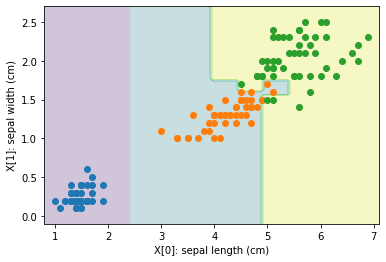

In [91]:
plotDecisao(Arvore(), X, y)

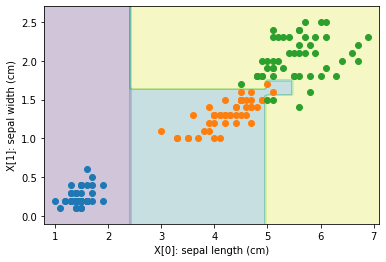

In [92]:
from sklearn.tree import DecisionTreeClassifier
plotDecisao(DecisionTreeClassifier(), X, y)

In [93]:
from sklearn.model_selection import cross_validate
scores = cross_validate(Arvore(), X, y)
scores['test_score'], np.mean(scores['test_score'])

(array([0.96666667, 0.96666667, 0.93333333, 0.93333333, 1.        ]), 0.96)

Base 1 de classificador

In [94]:
request = fetch_openml(data_id=37,as_frame=True)
X = request.data
y = request.target.map({"tested_negative":0,"tested_positive":1})

In [95]:
X

,preg,plas,pres,skin,insu,mass,pedi,age
0,6.0,148.0,72.0,35.0,0.0,33.6,0.627,50.0
1,1.0,85.0,66.0,29.0,0.0,26.6,0.351,31.0
2,8.0,183.0,64.0,0.0,0.0,23.3,0.672,32.0
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0
4,0.0,137.0,40.0,35.0,168.0,43.1,2.288,33.0
...,...,...,...,...,...,...,...,...
763,10.0,101.0,76.0,48.0,180.0,32.9,0.171,63.0
764,2.0,122.0,70.0,27.0,0.0,36.8,0.340,27.0
765,5.0,121.0,72.0,23.0,112.0,26.2,0.245,30.0
766,1.0,126.0,60.0,0.0,0.0,30.1,0.349,47.0


In [96]:
scores = cross_validate(DecisionTreeClassifier(), X, y)
scores['test_score'], np.mean(scores['test_score'])

(array([0.66233766, 0.65584416, 0.69480519, 0.78431373, 0.71895425]),
 0.7032509973686445)

In [97]:
scores = cross_validate(Arvore(), X, y)
scores['test_score'], np.mean(scores['test_score'])

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "<ipython-input-89-00f348bb1521>", line 3, in fit
    self.caracteristica, self.valor, self.imp = melhorCaracteristica(X, y)
  File "<ipython-input-88-141afd391bfc>", line 5, in melhorCaracteristica
    valor, imp = melhorValor(X[:,caracteristica], y)
  File "/usr/local/lib/python3.7/dist-packages/pandas/core/fra

(array([nan, nan, nan, nan, nan]), nan)

Base 2 de classificador

In [98]:
request = fetch_openml(data_id=1489,as_frame=True)
X = request.data
y = request.target
X

,V1,V2,V3,V4,V5
0,0.489927,-0.451528,-1.047990,-0.598693,-0.020418
1,-0.641265,0.109245,0.292130,-0.916804,0.240223
2,0.870593,-0.459862,0.578159,0.806634,0.835248
3,-0.628439,-0.316284,1.934295,-1.427099,-0.136583
4,-0.596399,0.015938,2.043206,-1.688448,-0.948127
...,...,...,...,...,...
5399,-0.658318,1.331760,-0.081621,1.794253,-1.082181
5400,-0.044375,-0.010512,0.030989,-0.019379,1.281061
5401,0.246882,-0.793228,1.190101,1.423194,-1.303036
5402,-0.778907,-0.383111,1.727029,-1.432389,-1.208085


In [99]:
scores = cross_validate(DecisionTreeClassifier(), X, y)
scores['test_score'], np.mean(scores['test_score'])

(array([0.86493987, 0.87789084, 0.86956522, 0.87696577, 0.86481481]),
 0.8708353033884949)

In [100]:
scores = cross_validate(Arvore(), X, y)
scores['test_score'], np.mean(scores['test_score'])

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "<ipython-input-89-00f348bb1521>", line 3, in fit
    self.caracteristica, self.valor, self.imp = melhorCaracteristica(X, y)
  File "<ipython-input-88-141afd391bfc>", line 5, in melhorCaracteristica
    valor, imp = melhorValor(X[:,caracteristica], y)
  File "/usr/local/lib/python3.7/dist-packages/pandas/core/fra

(array([nan, nan, nan, nan, nan]), nan)

Base 3 de classificador

In [101]:
request = fetch_openml(data_id=1504)
X = request.data
y = request.target
X

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33
0,42.0,50.0,270900.0,270944.0,267.0,17.0,44.0,24220.0,76.0,108.0,...,1.6435,0.8182,-0.2913,0.5822,1.0,0.0,0.0,0.0,0.0,0.0
1,645.0,651.0,2538079.0,2538108.0,108.0,10.0,30.0,11397.0,84.0,123.0,...,1.4624,0.7931,-0.1756,0.2984,1.0,0.0,0.0,0.0,0.0,0.0
2,829.0,835.0,1553913.0,1553931.0,71.0,8.0,19.0,7972.0,99.0,125.0,...,1.2553,0.6667,-0.1228,0.2150,1.0,0.0,0.0,0.0,0.0,0.0
3,853.0,860.0,369370.0,369415.0,176.0,13.0,45.0,18996.0,99.0,126.0,...,1.6532,0.8444,-0.1568,0.5212,1.0,0.0,0.0,0.0,0.0,0.0
4,1289.0,1306.0,498078.0,498335.0,2409.0,60.0,260.0,246930.0,37.0,126.0,...,2.4099,0.9338,-0.1992,1.0000,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1936,249.0,277.0,325780.0,325796.0,273.0,54.0,22.0,35033.0,119.0,141.0,...,1.2041,-0.4286,0.0026,0.7254,0.0,0.0,0.0,0.0,0.0,0.0
1937,144.0,175.0,340581.0,340598.0,287.0,44.0,24.0,34599.0,112.0,133.0,...,1.2305,-0.4516,-0.0582,0.8173,0.0,0.0,0.0,0.0,0.0,0.0
1938,145.0,174.0,386779.0,386794.0,292.0,40.0,22.0,37572.0,120.0,140.0,...,1.1761,-0.4828,0.0052,0.7079,0.0,0.0,0.0,0.0,0.0,0.0
1939,137.0,170.0,422497.0,422528.0,419.0,97.0,47.0,52715.0,117.0,140.0,...,1.4914,-0.0606,-0.0171,0.9919,0.0,0.0,0.0,0.0,0.0,0.0


In [102]:
scores = cross_validate(DecisionTreeClassifier(), X, y)
scores['test_score'], np.mean(scores['test_score'])

(array([0.59383033, 1.        , 1.        , 0.85824742, 1.        ]),
 0.8904155513741288)

In [103]:
scores = cross_validate(Arvore(), X, y)
scores['test_score'], np.mean(scores['test_score'])

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "<ipython-input-89-00f348bb1521>", line 3, in fit
    self.caracteristica, self.valor, self.imp = melhorCaracteristica(X, y)
  File "<ipython-input-88-141afd391bfc>", line 5, in melhorCaracteristica
    valor, imp = melhorValor(X[:,caracteristica], y)
  File "/usr/local/lib/python3.7/dist-packages/pandas/core/fra

(array([nan, nan, nan, nan, nan]), nan)